# Computational analysis

For this analysis, three datasets are required. These are;

 1. Kenya boundary shapefile
 2. Kenya Population count by spatial distribution

We will need some packages to get started.

In [62]:
import os                 # for basic operating system functions
import rasterio
import warnings
import numpy as np
import geopandas as gpd   # For working with geospatial dataframes
import matplotlib.pyplot as plt
import pandas as pd       # To load .csv data as a dataframe
import seaborn as sns
from rasterio.mask import mask
from rasterstats import zonal_stats
from shapely.geometry import MultiPolygon
warnings.filterwarnings('ignore')
from colorspacious import cspace_converter

## 1. Process Kenya boundary 

First we obtain a csv country metadafile containing information about 250 territories and store it in a data directory

In [6]:
os.getcwd()

'C:\\Users\\bmwan\\Desktop\\5.2\\Link Budget'

In [5]:
os.chdir("C:/Users/bmwan/Desktop/5.2/Link Budget")

In [4]:
metadata_file = os.path.join('data', 'countries.csv')

Next we create a function that read the country of interest, process the boundary information and store it in a folder named by the country's **"ISO3"** code as well as create regions subfolder to contain the processed shapefiles. For instance, Kenya will be **"KEN"**


In [49]:
def country_directory(csv_filename, country_iso3):
    """
    Create country folder and regions subfolder within it.
    
    Parameters
    ----------
    csv_filename : string
        Name of the country metadata file.
    country_iso3 : string
        Country iso3 to be processed.
        
    Returns
    -------
    output : list
        List containing country ISO3 and gid_region
    """
    countries = pd.read_csv(csv_filename, encoding = 'latin-1')
    
    output = []
    
    for idx, country in countries.iterrows():
        
        if not country['iso3'] == country_iso3: #If the current country iso3 does not match the entered iso3...
            continue                            #continue in the loop to the next country

        else:   
            iso3 = country['iso3']
            gid_region = country['gid_region']
            country_name = country['country']
        
        output.append(iso3)
        output.append(gid_region)
        
        country_folder_path = os.path.join('data', 'processed', iso3) #Create folder called "processed" to store
        if not os.path.exists(country_folder_path):                   #country folder
            os.makedirs(country_folder_path)                          #Only create folder if it doest exist already
            
        regions_folder_path = os.path.join('data', 'processed', iso3, 'regions') #Create regions folder within
        if not os.path.exists(regions_folder_path):
            os.makedirs(regions_folder_path)

        print('processing {}'.format(country_name))      
    
    return output

We then use the function to create the folder for Kenya

In [50]:
country_directory(metadata_file, 'KEN')

processing Kenya


['KEN', 1]

Next we download global administrative maps data from https://gadm.org/download_world.html for the whole world. The current GADM version is 4.1 consisting of 400,276 administrative areas globally.

The data is downloaded as a single database in GeoPackage format and stored in the folder called **"raw"**

We then specify the location of the data

In [63]:
boundary_data = os.path.join('data', 'raw', 'gadm36_1.shp') 

We create a function that read the global administrative boundaries, select a country that we specify using the **"ISO3"** code process the boundaries and store in the corresponding folder.  

In [52]:
def country_boundary(boundary_data_path, country_iso3, gid_level):
    """
    Process country shapefile.
    
    Parameters
    ----------
    boundary_data_path : string
        Location of the GADM boundary data.
    country_iso3 : string
        Country iso3 to be processed.
    gid_level: string
        GID boundary spatial level to process
        
    Returns
    -------
    none  
    """
    global_boundaries = gpd.read_file(boundary_data_path)
    
    iso3 = country_directory(metadata_file, country_iso3)[0]
    gid_region = country_directory(metadata_file, country_iso3)[1]
    
    country_boundaries = global_boundaries[global_boundaries[gid_level] == iso3]
    gid_level_name = country_boundaries['NAME_1']
    
    filename = 'gadm_{}.shp'.format(gid_region)
    path_out = os.path.join('data', 'processed', iso3, 'regions', filename)
    country_boundaries.to_file(path_out)
    
    print('processing {}'.format(gid_level_name))
    
    return None

We then apply our function for Kenya, (*'ISO3'* = *'KEN'*)

In [53]:
country_boundary(boundary_data, 'KEN', 'GID_0')

processing Kenya
processing Kenya
processing 194404       Baringo
194405       Baringo
194406       Baringo
194407       Baringo
194408       Baringo
             ...    
195845    West Pokot
195846    West Pokot
195847    West Pokot
195848    West Pokot
195849    West Pokot
Name: NAME_1, Length: 1446, dtype: object


## 2. Kenya Population count by spatial distribution

Next, we need to download and process population data

The population count data is downloaded from WorldPop website (https://hub.worldpop.org/geodata/listing?id=64). 

The data downloaded is the unconstrained global mosaics 2000-2020 for 2020. The layer represent the estimated total number of people per grid-cell, in Geotiff format at a resolution of 30 arc (approximately 1km at the equator), in the WGS84 Geographic Coordinate System.

The downloaded data is stored in the *"raw"* folder.

We specify the location of the data and load the layer to raster input-output (rasterio) object

#### Preliminary data check 

In [47]:
filename = ("C:/Users/bmwan/Desktop/5.2/Link Budget/data/raw/ppp_2020_1km_Aggregated.tif")
folder = os.path.join('data', 'raw', 'worldpop')
path_population = os.path.join(folder, filename)

These set of cells are just to ensure that both the data layers are working properly as well as checking out their contents.


In [12]:
my_raster_image = rasterio.open(path_population)
my_raster_image

<open DatasetReader name='C:/Users/bmwan/Desktop/5.2/Link Budget/data/raw/ppp_2020_1km_Aggregated.tif' mode='r'>

We can then access the Python API interface for the .tif population layer file based on the Numpy N-dimensional arrays

<div class="alert alert-block alert-warning">

<b>!! Attention !!</b> This my take long since it is loading the whole world!.

</div>

In [13]:
data = my_raster_image.read(1)
print(data)

KeyboardInterrupt: 

We now query our population raster layer using the Kenyan boundary shapefile processed in section 1.

Let us load the processed Kenyan shapefile

In [64]:
filename = 'gadm_1.shp'
path_boundary = os.path.join('data', 'processed', 'KEN', 'regions', filename)
boundaries = gpd.read_file(path_boundary, crs = 'epsg:4326')
boundaries

,UID,GID_0,ID_0,NAME_0,GID_1,ID_1,NAME_1,VARNAME_1,NL_NAME_1,HASC_1,...,GID_5,ID_5,NAME_5,CC_5,TYPE_5,ENGTYPE_5,REGION,VARREGION,zone,geometry
0,140309,KEN,118.0,Kenya,KEN.1_1,1.0,Baringo,NaN,NaN,KE.BA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,"POLYGON ((35.87727 -0.02973, 35.87699 -0.02947..."
1,139076,KEN,118.0,Kenya,KEN.1_1,1.0,Baringo,NaN,NaN,KE.BA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,"POLYGON ((35.85098 0.49770, 35.85109 0.49729, ..."
2,139156,KEN,118.0,Kenya,KEN.1_1,1.0,Baringo,NaN,NaN,KE.BA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,"POLYGON ((35.75417 0.53366, 35.75393 0.53313, ..."
3,139248,KEN,118.0,Kenya,KEN.1_1,1.0,Baringo,NaN,NaN,KE.BA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,"POLYGON ((35.78914 0.44566, 35.78886 0.44554, ..."
4,139487,KEN,118.0,Kenya,KEN.1_1,1.0,Baringo,NaN,NaN,KE.BA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,"POLYGON ((35.79961 0.34833, 35.79943 0.34767, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1441,136997,KEN,118.0,Kenya,KEN.47_1,47.0,West Pokot,NaN,NaN,KE.WP,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,"POLYGON ((35.56500 1.52998, 35.56509 1.53012, ..."
1442,136883,KEN,118.0,Kenya,KEN.47_1,47.0,West Pokot,NaN,NaN,KE.WP,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,"POLYGON ((35.54330 1.62346, 35.54320 1.62339, ..."
1443,137144,KEN,118.0,Kenya,KEN.47_1,47.0,West Pokot,NaN,NaN,KE.WP,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,"POLYGON ((35.34214 1.51081, 35.35437 1.51645, ..."
1444,137105,KEN,118.0,Kenya,KEN.47_1,47.0,West Pokot,NaN,NaN,KE.WP,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,"POLYGON ((35.15631 1.49415, 35.15616 1.49424, ..."


#### Process Kenyan population layer

We now write a function that load the data layer, affine function, eliminate negative cell numbers, sum all the cells within the boundary of interest and return a csv file for plotting.

In [65]:
def process_population_tif(data_name, grid_level):
    """
    Process population layer.
    
    Parameters
    ----------
    data_name: string
        Filename of the population raster layer
    gid_level: string
        GID boundary spatial level to process
        
    Returns
    -------
    output: dictionary.
        Dictionary containing the country population and grid level
    """
    output = []
    for idx, boundary in boundaries.iterrows():
        
        print('Working on {}'.format(boundary['NAME_1']))
        
        with rasterio.open(data_name) as src:
            
            affine = src.transform
            array = src.read(1)
            array[array <= 0] = 0
            
            population = [i['sum'] for i in zonal_stats(
                boundary['geometry'], array, nodata = 255,
                stats = ['sum'], affine = affine)][0]
            output.append({
                'NAME_1': boundary['NAME_1'],
                'GID_1': boundary[grid_level],
                'population': population
            })
            
    return output

We now apply the function to our population layer



In [66]:
filename = ("C:/Users/bmwan/Desktop/5.2/Link Budget/data/raw/ppp_2020_1km_Aggregated.tif")
folder = os.path.join('data', 'raw', 'worldpop')
path_population = os.path.join(folder, filename)
pop = process_population_tif(path_population, 'GID_1')

Working on Baringo


KeyboardInterrupt: 

And then we store our results as csv file in the *processed/KEN* folder

In [46]:
pop_results = pd.DataFrame(pop)
path_out = os.path.join('data', 'processed', 'KEN', 'population.csv')
pop_results.to_csv(path_out)

NameError: name 'pop' is not defined

In [87]:
path_out = os.path.join("C:/Users/bmwan/Desktop/5.2/Link Budget/data/processed/KEN/population.csv")
pop_results = pd.read_csv(path_out)

#### Plotting population map 

In [30]:
pop_results.head()

,Unnamed: 0,NAME_1,GID_1,population
0,0,Baringo,KEN.1_1,20382.544922
1,1,Baringo,KEN.1_1,32307.335938
2,2,Baringo,KEN.1_1,20890.990234
3,3,Baringo,KEN.1_1,42170.015625
4,4,Baringo,KEN.1_1,17102.597656


First, we import country boundary.

In [78]:
#import our boundaries data
filename = 'regions_1_KEN.shp'
path_in = os.path.join("C:/Users/bmwan/Desktop/5.2/Link Budget/data/processed/KEN/regions/", filename) 
country_boundaries = gpd.read_file(path_in)
country_boundaries.head(5)

,GID_0,NAME_0,GID_1,NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,geometry
0,KEN,Kenya,KEN.1_1,Baringo,County,County,30,KE.BA,"POLYGON ((35.84734 -0.07654, 35.82207 -0.11243..."
1,KEN,Kenya,KEN.2_1,Bomet,County,County,36,KE.BO,"POLYGON ((35.26193 -1.01562, 35.24075 -1.03093..."
2,KEN,Kenya,KEN.3_1,Bungoma,County,County,39,KE.BN,"POLYGON ((34.45476 0.47293, 34.43480 0.46785, ..."
3,KEN,Kenya,KEN.4_1,Busia,County,County,40,KE.BS,"POLYGON ((34.24632 0.31446, 34.23613 0.29631, ..."
4,KEN,Kenya,KEN.5_1,Elgeyo-Marakwet,County,County,28,KE.EM,"POLYGON ((35.58806 0.17453, 35.56753 0.19131, ..."


In [93]:
boundaries.head(5)

,GID_0,NAME_0,GID_1,NAME_1_x,TYPE_1,ENGTYPE_1,CC_1,HASC_1,geometry,Unnamed: 0,population,area
0,KEN,Kenya,KEN.1_1,Baringo,County,County,30,KE.BA,"POLYGON ((35.84734 -0.07654, 35.82207 -0.11243...",0,20382.544922,0.880323
1,KEN,Kenya,KEN.1_1,Baringo,County,County,30,KE.BA,"POLYGON ((35.84734 -0.07654, 35.82207 -0.11243...",1,32307.335938,0.880323
2,KEN,Kenya,KEN.1_1,Baringo,County,County,30,KE.BA,"POLYGON ((35.84734 -0.07654, 35.82207 -0.11243...",2,20890.990234,0.880323
3,KEN,Kenya,KEN.1_1,Baringo,County,County,30,KE.BA,"POLYGON ((35.84734 -0.07654, 35.82207 -0.11243...",3,42170.015625,0.880323
4,KEN,Kenya,KEN.1_1,Baringo,County,County,30,KE.BA,"POLYGON ((35.84734 -0.07654, 35.82207 -0.11243...",4,17102.597656,0.880323


In [89]:
boundaries.columns

Index(['GID_0', 'NAME_0', 'GID_1', 'NAME_1_x', 'TYPE_1', 'ENGTYPE_1', 'CC_1',
       'HASC_1', 'geometry', 'Unnamed: 0', 'population', 'area'],
      dtype='object')

In [92]:
boundaries['GID_1','NAME_1_x','geometry']
boundaries['area'] = boundaries.geometry.area
boundaries.to_csv("C:/Users/bmwan/Desktop/5.2/Link Budget/data/processed/Boundaries/b_1.csv")

KeyError: ('GID_1', 'NAME_1_x', 'geometry')

In [33]:
country_boundaries = country_boundaries[['NAME_1', 'GID_1', 'geometry']]
country_boundaries.head(5)

,NAME_1,GID_1,geometry
0,Baringo,KEN.1_1,"POLYGON ((35.84734 -0.07654, 35.82207 -0.11243..."
1,Bomet,KEN.2_1,"POLYGON ((35.26193 -1.01562, 35.24075 -1.03093..."
2,Bungoma,KEN.3_1,"POLYGON ((34.45476 0.47293, 34.43480 0.46785, ..."
3,Busia,KEN.4_1,"POLYGON ((34.24632 0.31446, 34.23613 0.29631, ..."
4,Elgeyo-Marakwet,KEN.5_1,"POLYGON ((35.58806 0.17453, 35.56753 0.19131, ..."


In [21]:
country_boundaries.head()

,GID_0,NAME_0,GID_1,NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,geometry
0,KEN,Kenya,KEN.1_1,Baringo,County,County,30,KE.BA,"POLYGON ((35.84734 -0.07654, 35.82207 -0.11243..."
1,KEN,Kenya,KEN.2_1,Bomet,County,County,36,KE.BO,"POLYGON ((35.26193 -1.01562, 35.24075 -1.03093..."
2,KEN,Kenya,KEN.3_1,Bungoma,County,County,39,KE.BN,"POLYGON ((34.45476 0.47293, 34.43480 0.46785, ..."
3,KEN,Kenya,KEN.4_1,Busia,County,County,40,KE.BS,"POLYGON ((34.24632 0.31446, 34.23613 0.29631, ..."
4,KEN,Kenya,KEN.5_1,Elgeyo-Marakwet,County,County,28,KE.EM,"POLYGON ((35.58806 0.17453, 35.56753 0.19131, ..."


And then we import the previously-saved population csv file.

In [72]:
boundaries = country_boundaries.merge(pop_results, left_on = 'GID_1', right_on = 'GID_1')
boundaries = boundaries.drop(['NAME_1_y'], axis = 1)
boundaries.to_csv("population.csv")
boundaries.head(5)

,GID_0,NAME_0,GID_1,NAME_1_x,TYPE_1,ENGTYPE_1,CC_1,HASC_1,geometry,Unnamed: 0,population
0,KEN,Kenya,KEN.1_1,Baringo,County,County,30,KE.BA,"POLYGON ((35.84734 -0.07654, 35.82207 -0.11243...",0,20382.544922
1,KEN,Kenya,KEN.1_1,Baringo,County,County,30,KE.BA,"POLYGON ((35.84734 -0.07654, 35.82207 -0.11243...",1,32307.335938
2,KEN,Kenya,KEN.1_1,Baringo,County,County,30,KE.BA,"POLYGON ((35.84734 -0.07654, 35.82207 -0.11243...",2,20890.990234
3,KEN,Kenya,KEN.1_1,Baringo,County,County,30,KE.BA,"POLYGON ((35.84734 -0.07654, 35.82207 -0.11243...",3,42170.015625
4,KEN,Kenya,KEN.1_1,Baringo,County,County,30,KE.BA,"POLYGON ((35.84734 -0.07654, 35.82207 -0.11243...",4,17102.597656


In [28]:
#import our population data
filename = "C:/Users/bmwan/Desktop/5.2/Link Budget/data/processed/KEN/population.csv"
path_in = os.path.join('data', 'processed', 'KEN', filename) 
data = pd.read_csv(path_in)

First, we'll show the range of each colormap

In [29]:
cmaps = {}

gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))


def plot_color_gradients(category, cmap_list):
    nrows = len(cmap_list)
    figh = 0.35 + 0.15 + (nrows + (nrows - 1) * 0.1) * 0.22
    fig, axs = plt.subplots(nrows=nrows + 1, figsize=(6.4, figh))
    fig.subplots_adjust(top=1 - 0.35 / figh, bottom=0.15 / figh,
                        left=0.2, right=0.99)
    axs[0].set_title(f'{category} colormaps', fontsize=14)

    for ax, name in zip(axs, cmap_list):
        ax.imshow(gradient, aspect='auto', cmap=plt.colormaps[name])
        ax.text(-0.01, 0.5, name, va='center', ha='right', fontsize=10,
                transform=ax.transAxes)
    for ax in axs:
        ax.set_axis_off()
    cmaps[category] = cmap_list

We then write a function to plot the data.

<div class="alert alert-block alert-info">
    
<b>Note:</b> You need to manually adjust the bins and labels inside the function depending on the distribution of your dataset.

</div>

In [30]:
def plot_population(country_boundaries, csv_data, gid_level, iso3):
    """
    Plots the country's population at sub-region level.
    
    Parameters
    ----------
    country_boundaries : string
        Name of the country boundary .shp file
    csv_data : string
        Name of the csv file containing the population data
        at sub-regional level
    gid_level : string
        Name of the GID level
    country_iso3 = string
        ISO3 of the country
    
    Return
    ------
    fig : python object
        A map of population distribution. 
    """
    plot_color_gradients ('Qualitative',
                     ['Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2',
                      'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b',
                      'tab20c'])
    boundaries = country_boundaries.merge(csv_data, left_on = gid_level, #merge our population data onto our boundaries
                                  right_on = gid_level)
    
    bins = [-1e6, 10000, 20000, 30000, 40000, 50000, 60000,        #define value bins and then labels for each one
            70000, 80000, 90000, 100000, 110000, 120000, 130000,      # 24
            140000, 150000, 160000, 170000, 180000, 190000, 200000,
            210000, 220000, 230000]
    
    labels = [
                '1-10k','10-20k','20-30k', '30-40k',      #46
                '40-50k', '50-60k','60-70k', '70-80k', 
                '80-90k', '90-100k',
                '100-110k', '110-120k','120-130k', '130-140k',
                '140-150k', '150-160k', '160-170k', '170-180k',
                '180-190k', '190-200k','200-210k', '210-220k', 
                '>220k'
                ]
     
    boundaries['bin'] = pd.cut(                                   #create a new variable with our bin labels
        boundaries['population'], 
        bins = bins,
        labels = labels
    )   
    
    sns.set(font_scale = 0.9)                                     #open a new seaborn figure
    fig, ax = plt.subplots(1, 1, figsize = (8, 8))

    base = boundaries.plot(column = 'bin', ax = ax,               #now plot our data using pandas plot
                           cmap = 'Blues', linewidth = 0, 
                           legend = True, antialiased = False)
    #allocate a plot title 
    n = len(boundaries)
    name = ' Kenyan Population by Sub-Region(n={})'.format(n)
    fig.suptitle(name)
    
    filename = 'kenyan_population_2.png'
    folder_out = os.path.join('data', 'processed', iso3)    
    if not os.path.exists(folder_out):  
        os.makedirs(folder_out) 
    path_out = os.path.join(folder_out, filename)
    fig.savefig(path_out)   
    plt.close(fig)

    fig
    
    return fig

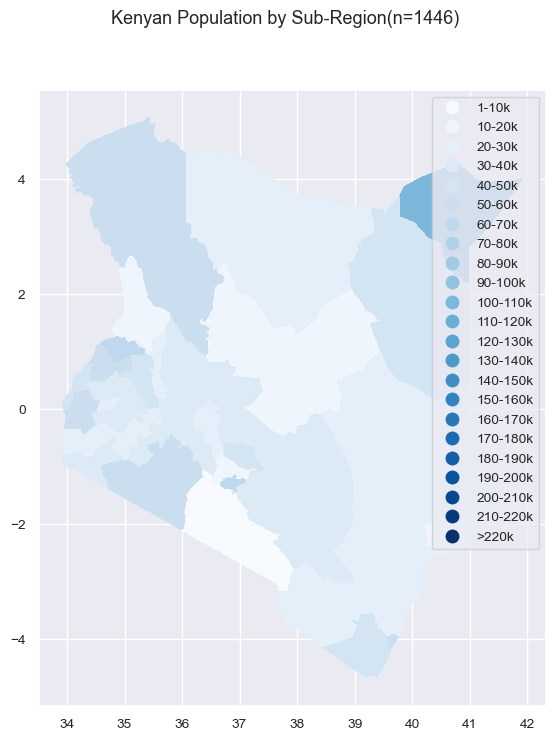

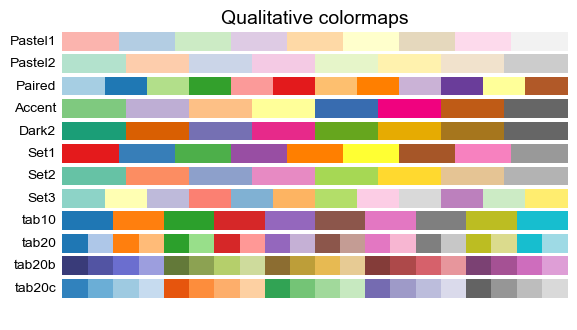

In [31]:
plot_population(country_boundaries, pop_results, 'GID_1', 'KEN')